# Exploring Arrow Ecosystem

In this Jupyter notebook, we'll explore the Arrow ecosystem. For that, we'll use [AWS Digital Assets Dataset](https://github.com/aws-samples/digital-assets-examples) which pulls data from the public Ethereum blockchain and normalizes data into tabular data structures for blocks, transactions, and additional tables for data inside a block. 

The dataset is available in Parquet format on Amazon S3 at the following location: `s3://aws-public-blockchain/v1.0/eth/`.

## Setup 

In [2]:
import duckdb

import pyarrow as pa
import pyarrow.dataset as ds

from deltalake import DeltaTable
from deltalake.writer import write_deltalake
from pyarrow import fs

con = duckdb.connect()

In [3]:
s3 = fs.S3FileSystem(region="us-east-2")
s3_eth_blocks_location = "s3://aws-public-blockchain/v1.0/eth/blocks"

In [4]:
blocks = ds.dataset(s3_eth_blocks_location, format="parquet", partitioning="hive")

In [5]:
blocks.head(5).to_pandas()

,difficulty,hash,miner,nonce,number,size,timestamp,total_difficulty,base_fee_per_gas,gas_limit,...,extra_data,logs_bloom,parent_hash,state_root,receipts_root,transactions_root,sha3_uncles,transaction_count,date,last_modified
0,1.028563e+11,0xb41d6002c750bfabc4ca507000d32d16367ae0402812...,0x9dfc0377058b7b9eb277421769b56df1395705f0,0x7f30a333095c5c64,3730,546,2015-07-30 18:23:09,1.798890e+14,NaN,5000,...,0x476574682f76312e302e302d66633739643332642f6c...,0x00000000000000000000000000000000000000000000...,0x846078d6d12be57c1b5fb87f3cf2c87f9acc07f789cf...,0xe35267cdfcaff683bb74ccf6ace2ab505454cdd10761...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0,2015-07-30,2022-09-11 23:35:56.747049
1,1.818963e+10,0x12ef0c55f6a6adcd43b65fdf0c356927b82ef30fb8a7...,0x1b7047b4338acf65be94c1a3e8c5c9338ad7d67c,0xc79245b4967062c4,131,539,2015-07-30 15:35:07,2.326528e+12,NaN,5000,...,0x426974636f696e2069732054484520426c6f636b6368...,0x00000000000000000000000000000000000000000000...,0x2807e7d5796039fa4040c5db859dc599b7ac73de3897...,0xb516807b88579af98aa7531c8492d0311ce727df4cdb...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0,2015-07-30,2022-09-11 23:35:09.004149
2,3.150146e+10,0x6fd8a2720224b4dca3b3c8139d5d695462ba342709ca...,0x0e858640eb9cbeee16b74124658815bb2b5c0686,0xa9b02885aee63128,1256,546,2015-07-30 16:11:21,2.960247e+13,NaN,5000,...,0x476574682f76312e302e302d30636463373634372f6c...,0x00000000000000000000000000000000000000000000...,0x4a0526dcea5342341d55cbc3c054629690a57046e9a4...,0x49a5916f09bc1ded5281eebe85823db0be5574738a49...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0,2015-07-30,2022-09-11 23:35:24.124087
3,3.090740e+10,0x202df65f4ec4c27fd65d4c4d34c13343f46e9013ff0d...,0x9beb4d346c6309a9ce4f27393c6322c8f03a3be6,0xcffa11e09d7355fa,1217,546,2015-07-30 16:10:03,2.838524e+13,NaN,5000,...,0x476574682f7370616e6b7930312f76312e302e302f6c...,0x00000000000000000000000000000000000000000000...,0xdb8a95a61b222e044afe27b33a621823fc4f961899ed...,0x2b56db731a948d2301743ff8808465fe9dbf9bfede1c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0,2015-07-30,2022-09-11 23:35:23.636856
4,1.034101e+11,0x4b1a21458763697d810b197d0f3ae28b733db35cf597...,0x322df8fd261820c36234f806b15f51a2203a8f88,0xf0135edf3f857cec,3741,546,2015-07-30 18:23:53,1.810237e+14,NaN,5000,...,0x476574682f76312e302e302d66633739643332642f6c...,0x00000000000000000000000000000000000000000000...,0xc01370b102a0c675a83ed90526226a7044226d44daa0...,0xef86b96914f288f9010b0ff49bf7f4c232418a6bdcba...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0,2015-07-30,2022-09-11 23:35:56.914284


<AxesSubplot:xlabel='date'>

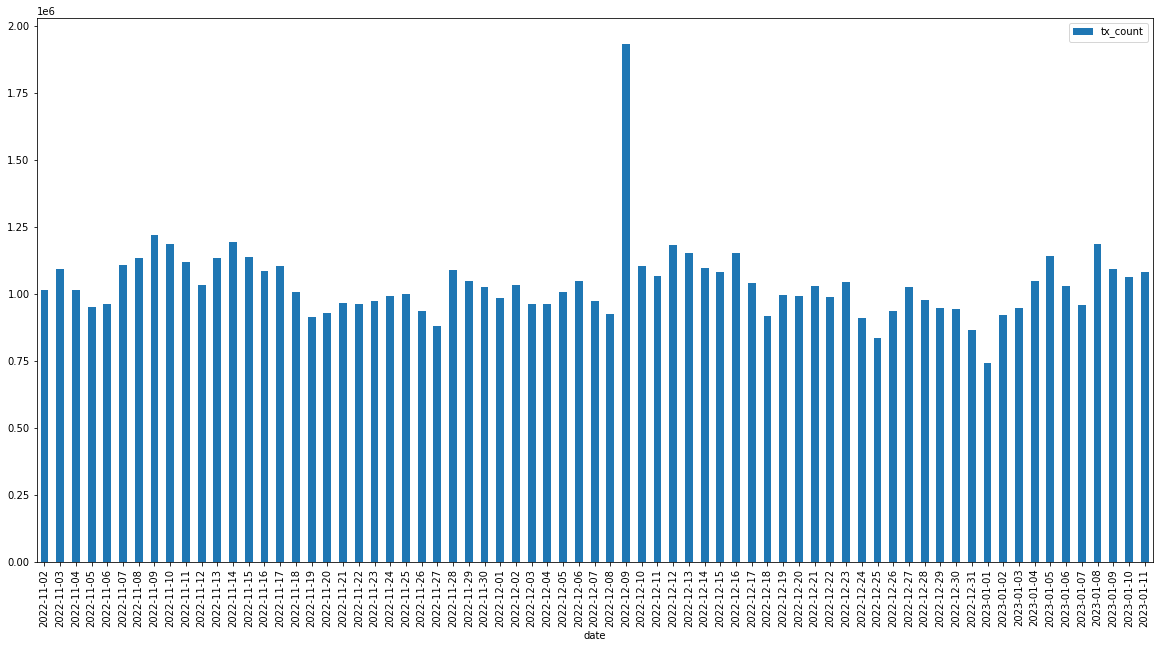

In [6]:
con.execute(
    """
    select 
        date,
        sum(transaction_count) as tx_count 
    from blocks 
    where 
        date > '2022-11-01'
    group by date 
    order by date
    """
).df().plot(x="date", y="tx_count", kind="bar", figsize=(20, 10))

In [7]:
scanner = blocks.scanner(
    columns=["difficulty", "hash", "miner", "state_root", "date"],
    filter=(ds.field("date") > "2022-12-01") & (ds.field("date") < "2023-01-01"),
)

In [8]:
scanner.head(5).to_pandas()

,difficulty,hash,miner,state_root,date
0,0.0,0x4379e19e699cfadfec8f4066b77e75725159c16ad7f0...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x75b981d534e8a6673294aa37fc4716bc4f91958094fa...,2022-12-02
1,0.0,0x36055641b76d077f3594c076309bdd5bd8b9f3f189e5...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0xd4e657b856665dccddbf5d607fbca13cf6c2b30a108c...,2022-12-02
2,0.0,0x8aa19b0cf8483e5371b4414dc732071bfe861af61ed4...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x1ade2aadccb69308d2b377aeca56e6e0e289a4d6b02f...,2022-12-02
3,0.0,0x85990a167ca1780e8999d5d4d14d4b8688c02602fb8d...,0x473780deaf4a2ac070bbba936b0cdefe7f267dfc,0xa857a789b45c7b14bd574aa55542a2de5c9f6ad3aaa0...,2022-12-02
4,0.0,0x13b507ab2b8ec4185bd80ca7337ac4927b287e0e40db...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x30df300050514ba4f00e7e05637ab0aa383b9cb2e067...,2022-12-02


In [9]:
con.execute(
    """
select
    count(*) as block_count
from scanner
"""
).df()

,block_count
0,214793


In [10]:
write_deltalake(
    "../datasets/blocks", scanner.to_reader(), mode="overwrite", partition_by=["date"]
)